[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/estadistica/blob/main/trabajo3/trabajo3.ipynb)

In [22]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# We will use some methods from the sklearn module
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

import scipy.stats as stats
from scipy.stats import bartlett, shapiro
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from IPython.display import display, Markdown

# Ejemplo vino

## Base de datos



### Carga y analisis simple de la base de datos

In [2]:
# Leer archivo csv

raw_data_url = "datosVino.csv"

# Leer el archivo CSV
df = pd.read_csv(raw_data_url)

# Mostrar las primeras filas del DataFrame
df.head()

,calidad,aroma,cuerpo,sabor,fuerza
0,9.8,3.3,2.8,3.1,4.1
1,12.6,4.4,4.9,3.5,3.9
2,11.9,3.9,5.3,4.8,4.7
3,11.1,3.9,2.6,3.1,3.6
4,13.3,5.6,5.1,5.5,5.1


### Funciones resumen

In [3]:
df.shape

(38, 5)

In [4]:
# Información resumida de los datos numericos
df.describe()

,calidad,aroma,cuerpo,sabor,fuerza
count,38.000000,38.000000,38.000000,38.000000,38.000000
mean,12.442105,4.847368,4.684211,4.768421,4.255263
std,2.035181,1.082474,0.824138,1.028014,0.738039
min,7.900000,3.300000,2.600000,2.900000,2.900000
25%,11.150000,4.125000,4.150000,4.225000,3.700000
50%,12.450000,4.650000,4.750000,4.800000,4.100000
75%,13.750000,5.450000,5.375000,5.500000,4.775000
max,16.100000,7.700000,6.600000,7.000000,6.000000


In [5]:
df.corr()

,calidad,aroma,cuerpo,sabor,fuerza
calidad,1.000000,0.710007,0.548273,0.789169,-0.048554
aroma,0.710007,1.000000,0.548910,0.736561,0.201644
cuerpo,0.548273,0.548910,1.000000,0.646659,0.152106
sabor,0.789169,0.736561,0.646659,1.000000,0.179761
fuerza,-0.048554,0.201644,0.152106,0.179761,1.000000


## Ajuste del modelo

In [12]:
# Para ajustar el modelo utilizando el modo fórmula, es necesario que los datos
# estén almacenados en un único dataframe.

modelo = smf.ols(
     formula = 'calidad ~ aroma+cuerpo+sabor+fuerza',
     data = df
)
modelo_res = modelo.fit()
print(modelo_res.summary())

                            OLS Regression Results                            
Dep. Variable:                calidad   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     19.81
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           2.14e-08
Time:                        10:23:49   Log-Likelihood:                -57.158
No. Observations:                  38   AIC:                             124.3
Df Residuals:                      33   BIC:                             132.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3173      1.473      4.289      0.0

## Anova del modelo

In [19]:
# Realizar el análisis ANOVA directamente sobre el modelo OLS ajustado (modelo_ols)
anova_modelo_res = sm.stats.anova_lm(modelo_res, typ=1)

# Mostrar los resultados de ANOVA
anova_modelo_res

,df,sum_sq,mean_sq,F,PR(>F)
aroma,1.0,77.256247,77.256247,56.577694,1.192281e-08
cuerpo,1.0,5.513287,5.513287,4.037590,5.273375e-02
sabor,1.0,18.308585,18.308585,13.408075,8.690983e-04
fuerza,1.0,7.113360,7.113360,5.209385,2.904237e-02
Residual,33.0,45.061153,1.365489,NaN,NaN


In [20]:
# Funcion miAnova de R
def miAnova(modelo):
    # Obtener la tabla ANOVA del modelo ajustado
    anova_table = sm.stats.anova_lm(modelo, typ=1)
    
    # Suma de cuadrados
    SSq = anova_table['sum_sq'].values
    
    # Número de predictores (k)
    k = len(SSq) - 1
    
    # Suma de cuadrados del modelo (SSR) y del error (SSE)
    SSR = np.sum(SSq[:k])
    SSE = SSq[k]
    
    # Grados de libertad
    df_error = anova_table['df'].values[k]
    
    # Cuadrados medios
    MSR = SSR / k
    MSE = SSE / df_error
    
    # Estadístico F
    F0 = MSR / MSE
    
    # Valor p
    VP = stats.f.sf(F0, k, df_error)
    
    # Crear tabla de resultados
    result = pd.DataFrame({
        'SumSq': [SSR, SSE],
        'Df': [k, df_error],
        'MeanSq': [MSR, MSE],
        'F0': [round(F0, 3), ' '],
        'P.value': [format(VP, '.3e'), ' ']
    }, index=['Modelo', 'Error'])
    
    print("Tabla ANOVA Modelo de Regresión\n")
    return result


In [21]:
miAnova(modelo_res)

Tabla ANOVA Modelo de Regresión



,SumSq,Df,MeanSq,F0,P.value
Modelo,108.191479,4.0,27.047870,19.808,2.141e-08
Error,45.061153,33.0,1.365489,,


## Todas las posibles regresiones

In [25]:
# Función para generar todas las combinaciones de variables y ajustar un modelo de regresión
def todas_regresiones_posibles(data, respuesta):
    variables_predictoras = list(data.columns)
    variables_predictoras.remove(respuesta)
    
    resultados = []

    # Probar todas las combinaciones de variables predictoras
    for k in range(1, len(variables_predictoras) + 1):
        for combo in itertools.combinations(variables_predictoras, k):
            # Definir el conjunto de predictores actual
            X = data[list(combo)]
            X = sm.add_constant(X)  # Agregar la constante (intercepto)
            y = data[respuesta]
            
            # Ajustar el modelo de regresión
            modelo = sm.OLS(y, X).fit()
            
            # Guardar los resultados del modelo
            resultados.append({
                'Predictoras': combo,
                'R2_adj': modelo.rsquared_adj,
                'AIC': modelo.aic,
                'BIC': modelo.bic
            })
    
    # Convertir los resultados a un DataFrame
    resultados_df = pd.DataFrame(resultados)
    
    return resultados_df


In [27]:
def todas_regresiones_posibles_completo(data, respuesta):
    variables_predictoras = list(data.columns)
    variables_predictoras.remove(respuesta)
    
    n = len(data)
    resultados = []

    # Probar todas las combinaciones de variables predictoras
    for k in range(1, len(variables_predictoras) + 1):
        for combo in itertools.combinations(variables_predictoras, k):
            # Definir el conjunto de predictores actual
            X = data[list(combo)]
            X = sm.add_constant(X)  # Agregar la constante (intercepto)
            y = data[respuesta]
            
            # Ajustar el modelo de regresión
            modelo = sm.OLS(y, X).fit()
            
            # Obtener los valores necesarios
            R2 = modelo.rsquared
            R2_adj = modelo.rsquared_adj
            SSE = np.sum(modelo.resid ** 2)  # Suma de cuadrados del error
            MSE = SSE / modelo.df_resid  # Error cuadrático medio
            Cp = SSE / MSE - (n - 2 * (k + 1))  # Criterio de Cp de Mallows
            
            # Guardar los resultados del modelo
            resultados.append({
                'Predictoras': combo,
                'R2': R2,
                'R2_adj': R2_adj,
                'SSE': SSE,
                'MSE': MSE,
                'Cp': Cp,
                'AIC': modelo.aic,
                'BIC': modelo.bic
            })
    
    # Convertir los resultados a un DataFrame
    resultados_df = pd.DataFrame(resultados)
    
    return resultados_df

In [28]:
# Ejemplo de uso (suponiendo que df es tu DataFrame)
resultados_posibles = todas_regresiones_posibles(df, 'calidad')

# Mostrar los mejores resultados
print(resultados_posibles.sort_values(by='R2_adj', ascending=False))

                       Predictoras    R2_adj         AIC         BIC
12          (aroma, sabor, fuerza)  0.679016  122.435369  128.985714
14  (aroma, cuerpo, sabor, fuerza)  0.670328  124.315834  132.503765
9                  (sabor, fuerza)  0.640842  125.807003  130.719762
5                   (aroma, sabor)  0.639529  125.945645  130.858403
13         (cuerpo, sabor, fuerza)  0.634076  127.414705  133.965050
10          (aroma, cuerpo, sabor)  0.629513  127.885631  134.435976
2                         (sabor,)  0.612309  127.782452  131.057625
7                  (cuerpo, sabor)  0.603849  129.532277  134.445035
11         (aroma, cuerpo, fuerza)  0.545508  135.651398  142.201742
6                  (aroma, fuerza)  0.516279  137.121348  142.034106
4                  (aroma, cuerpo)  0.513805  137.315226  142.227985
0                         (aroma,)  0.490336  138.177114  141.452286
1                        (cuerpo,)  0.281175  151.243987  154.519159
8                 (cuerpo, fuerza)

In [31]:
# Ejecutar la función con los datos
resultados_completos = todas_regresiones_posibles_completo(df, 'calidad')

# Mostrar los resultados ordenados por R2 ajustado
resultados_completos.sort_values(by='R2_adj', ascending=False)

,Predictoras,R2,R2_adj,SSE,MSE,Cp,AIC,BIC
12,"(aroma, sabor, fuerza)",0.705042,0.679016,45.203123,1.329504,4.0,122.435369,128.985714
14,"(aroma, cuerpo, sabor, fuerza)",0.705968,0.670328,45.061153,1.365489,5.0,124.315834,132.503765
9,"(sabor, fuerza)",0.660256,0.640842,52.066668,1.487619,3.0,125.807003,130.719762
5,"(aroma, sabor)",0.659014,0.639529,52.256978,1.493057,3.0,125.945645,130.858403
13,"(cuerpo, sabor, fuerza)",0.663745,0.634076,51.531916,1.515645,4.0,127.414705,133.965050
10,"(aroma, cuerpo, sabor)",0.659552,0.629513,52.174513,1.534545,4.0,127.885631,134.435976
2,"(sabor,)",0.622787,0.612309,57.808860,1.605802,2.0,127.782452,131.057625
7,"(cuerpo, sabor)",0.625262,0.603849,57.429521,1.640843,3.0,129.532277,134.445035
11,"(aroma, cuerpo, fuerza)",0.582358,0.545508,64.004693,1.882491,4.0,135.651398,142.201742
6,"(aroma, fuerza)",0.542426,0.516279,70.124405,2.003554,3.0,137.121348,142.034106


In [26]:
# Ejemplo de uso (suponiendo que df es tu DataFrame)
resultados_posibles = todas_regresiones_posibles(df, 'calidad')

# Mostrar los mejores resultados
print(resultados_posibles.sort_values(by='R2_adj', ascending=False))

                       Predictoras    R2_adj         AIC         BIC
12          (aroma, sabor, fuerza)  0.679016  122.435369  128.985714
14  (aroma, cuerpo, sabor, fuerza)  0.670328  124.315834  132.503765
9                  (sabor, fuerza)  0.640842  125.807003  130.719762
5                   (aroma, sabor)  0.639529  125.945645  130.858403
13         (cuerpo, sabor, fuerza)  0.634076  127.414705  133.965050
10          (aroma, cuerpo, sabor)  0.629513  127.885631  134.435976
2                         (sabor,)  0.612309  127.782452  131.057625
7                  (cuerpo, sabor)  0.603849  129.532277  134.445035
11         (aroma, cuerpo, fuerza)  0.545508  135.651398  142.201742
6                  (aroma, fuerza)  0.516279  137.121348  142.034106
4                  (aroma, cuerpo)  0.513805  137.315226  142.227985
0                         (aroma,)  0.490336  138.177114  141.452286
1                        (cuerpo,)  0.281175  151.243987  154.519159
8                 (cuerpo, fuerza)

 2 0.6603  0.6408  52.06667  6.1304 1.48762   

 (sabor, fuerza)  0.640842  125.807003  130.719762 

### Calculo de residuales estudentizados

In [33]:
# Obtener los residuos estudentizados utilizando OLSInfluence
influence = modelo_res.get_influence()
residuos_estudentizados = influence.resid_studentized_external

# Mostrar los residuos estudentizados
print(residuos_estudentizados)

[ 0.23085462  1.5219994   0.16210806  0.88864239  0.05222364  0.12162184
 -0.21265935  0.37737825  1.5739862   1.55967015  1.59336772  0.77977358
  0.28896522 -0.73791671  0.49440241  1.55885602  0.56768487  0.22730461
 -1.00204235 -2.81041681 -0.06259752 -0.22969718 -1.94937986 -1.6501413
 -1.1306834  -0.04068659  0.00995886 -0.40186731 -1.12330457 -1.47156586
 -1.06728647 -0.54548087  1.27597715  0.42741082  0.32400505  0.54639361
  0.50225373 -0.87858602]


### Grafico de residuales .vs. Valores predichos

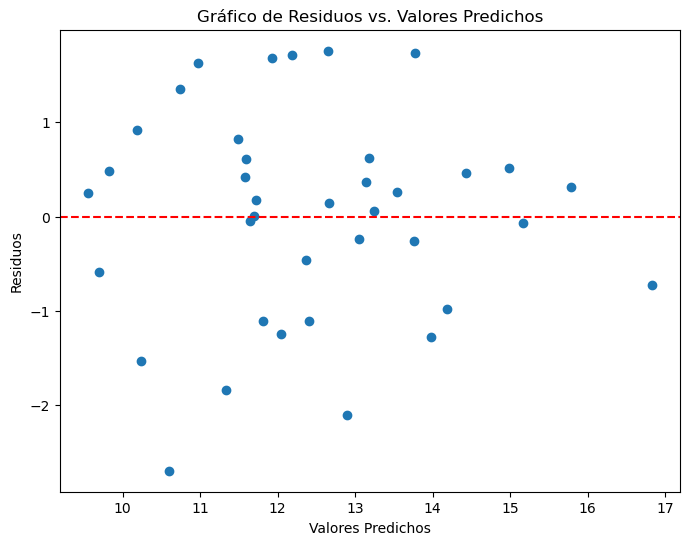

In [34]:
# Calcular los valores predichos
valores_predichos = modelo_res.fittedvalues

# Calcular los residuos
residuos = modelo_res.resid

# Crear el gráfico de residuos vs. valores predichos
plt.figure(figsize=(8, 6))
plt.scatter(valores_predichos, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Predichos')
plt.show()

## Test de normalidad

In [35]:
# Prueba de normalidad de Shapiro-Wilk sobre los residuos
shapiro_test = stats.shapiro(residuos)

# Mostrar los resultados de la prueba
shapiro_test

ShapiroResult(statistic=0.9654808044433594, pvalue=0.284563273191452)

### Grafico de cuantiles

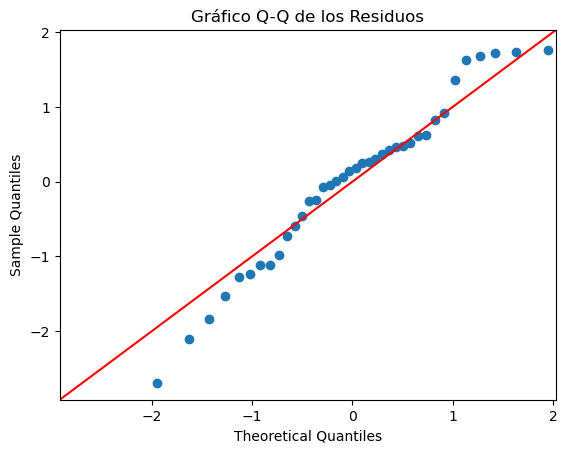

In [36]:
# Crear el gráfico Q-Q para los residuos
sm.qqplot(residuos, line ='45')
plt.title('Gráfico Q-Q de los Residuos')
plt.show()

### Prueba de corridas

In [37]:
def runs_test(data):
    """
    Realiza la prueba de corridas (Runs Test) para evaluar la aleatoriedad de una secuencia.
    
    Parámetros:
    data: lista o array de datos numéricos
    
    Retorna:
    valor p de la prueba
    """
    # Mediana de los datos
    median = np.median(data)
    
    # Convertir los datos en una secuencia de +1 y -1 según si están arriba o abajo de la mediana
    runs = np.diff(np.sign(data - median))
    
    # Contar el número de corridas (cambios en la secuencia)
    num_runs = np.sum(runs != 0) + 1
    
    # Contar el número de valores positivos y negativos
    n1 = np.sum(data > median)
    n2 = np.sum(data < median)
    
    # Calcular el valor esperado y la varianza
    expected_runs = (2 * n1 * n2) / (n1 + n2) + 1
    variance_runs = (2 * n1 * n2 * (2 * n1 * n2 - (n1 + n2))) / ((n1 + n2) ** 2 * (n1 + n2 - 1))
    
    # Calcular el estadístico Z
    z = (num_runs - expected_runs) / np.sqrt(variance_runs)
    
    # Calcular el valor p (bilateral)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return p_value

In [41]:
# Ejemplo de uso con una secuencia de datos ???
p_value = runs_test(residuos)
print(f"P-valor de la prueba de corridas: {p_value}")

P-valor de la prueba de corridas: 7.913076572418909e-05


In [42]:
# Calcular la estadística de Durbin-Watson para los residuos del modelo ajustado
dw_stat = durbin_watson(residuos)

dw_stat

0.8601181541895342

### Grafica de aleatoridad (Residuos vs tiempo)

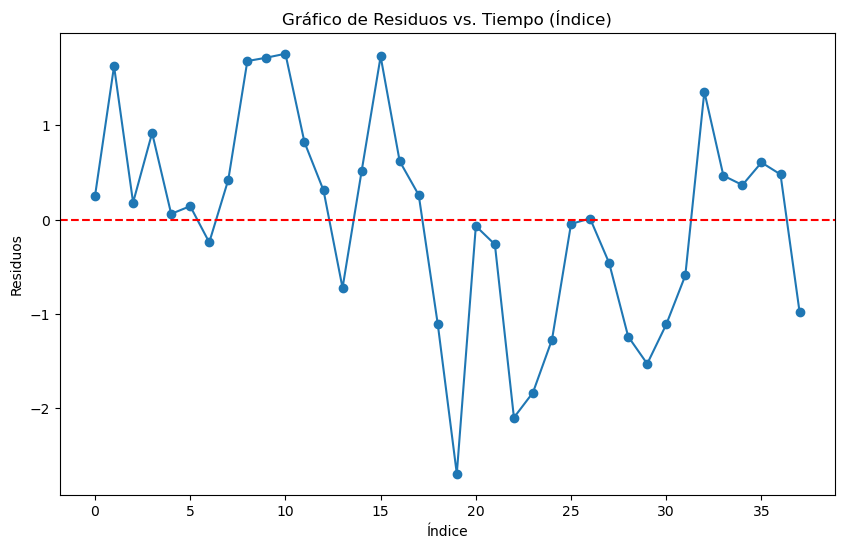

In [43]:
# Crear el gráfico de residuos vs. tiempo (índice de los datos)
plt.figure(figsize=(10, 6))
plt.plot(residuos, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Índice')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Tiempo (Índice)')
plt.show()

### Grafico de residuales .vs. valores predichos


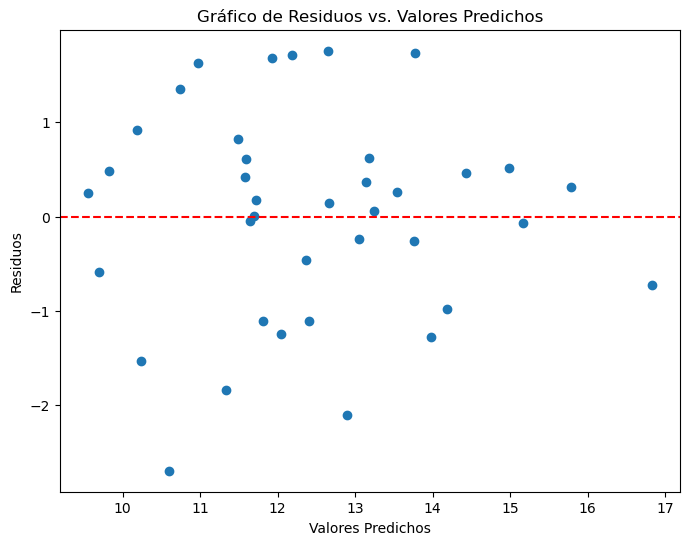

In [45]:
# Crear el gráfico de residuos vs. valores predichos
valores_predichos = modelo_res.fittedvalues  # Valores predichos por el modelo
residuos = modelo_res.resid  # Residuos del modelo

plt.figure(figsize=(8, 6))
plt.scatter(valores_predichos, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Predichos')
plt.show()

In [46]:
## Diagnostico de datos atipicos, de balanceo e influenciables

# Aca vamos...